In [23]:
import pandas as pd
import numpy as np
import os.path as op
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import OrderedDict
import json

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim

from sklearn.utils import shuffle

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Input the path to the image data in your computer
# img_path = "monthly_20d"
img_path = "/home/pqian/data/690/monthly_20d"

In [3]:
dfs = []
for year in range(1993, 2020):
    df = pd.read_feather(
        op.join(img_path, f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")
    )
    dfs.append(df)
label_df = pd.concat(dfs, ignore_index=True)
label_df["Ret_5d_binary"] = (label_df["Ret_5d"] > 0).astype(int)
label_df["Date"] = pd.to_datetime(label_df["Date"])
label_df["year"] = label_df["Date"].dt.year

In [4]:
label_df

,Date,StockID,MarketCap,Ret_5d,Ret_20d,Ret_60d,Ret_month,EWMA_vol,Ret_5d_binary,year
0,1993-01-29,10001,-1.512000e+04,3.240260e-07,0.035714,0.065641,0.017857,0.000417,1,1993
1,1993-02-26,10001,1.539000e+04,-8.771723e-03,0.002584,0.073561,0.011456,0.000342,0,1993
2,1993-03-31,10001,1.531875e+04,-8.771614e-03,0.105263,0.117841,0.070175,0.000471,0,1993
3,1993-04-30,10001,-1.639375e+04,3.278655e-02,-0.008199,0.085991,-0.008199,0.000389,1,1993
4,1993-05-28,10001,-1.625938e+04,2.809882e-02,0.086608,0.136763,0.103326,0.000566,1,1993
...,...,...,...,...,...,...,...,...,...,...
2196989,2019-08-30,93436,4.041284e+07,2.739224e-02,0.067639,0.490805,0.067639,0.000867,1,2019
2196990,2019-09-30,93436,4.335660e+07,-1.307759e-02,0.360527,0.765477,0.307429,0.000920,0,2019
2196991,2019-10-31,93436,5.676276e+07,6.547814e-02,0.047695,0.844879,0.047695,0.002130,1,2019
2196992,2019-11-29,93436,5.947004e+07,1.803443e-02,0.256895,1.057951,0.267897,0.001075,1,2019


In [5]:
def load_images_for_year(year, img_path, height, width):
    img_file = f"20d_month_has_vb_[20]_ma_{year}_images.dat"
    full_path = op.join(img_path, img_file)
    images = np.memmap(full_path, dtype=np.uint8, mode="r").reshape(-1, height, width)
    return images

In [6]:
image_map = {}
for year in range(1993, 2020):
    imgs = load_images_for_year(year, img_path, IMAGE_HEIGHT[20], IMAGE_WIDTH[20])
    idx = label_df["year"] == year
    image_map[year] = imgs
    label_df.loc[idx, "image_index"] = np.arange(len(imgs))

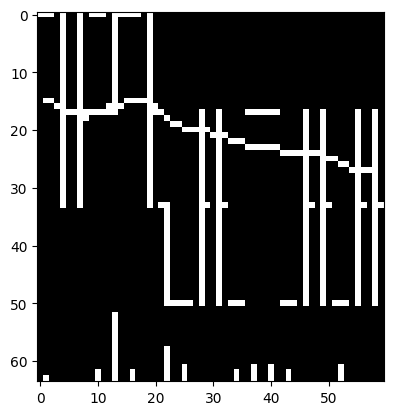

In [7]:
plt.imshow(image_map[1993][0], cmap="gray")

## dataset split - expanding-window split
- train/test/val
- For each window:
<br>
Train:      1993     —> val_start - 1
<br>
Val:        val_start       —> test_start - 1
<br>
Test:                      test_start     —> test_start + test_years

In [8]:
def to_dataloader(X, y, batch_size=32, shuffle_data=True):
    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # Add channel dim
    y_tensor = torch.tensor(y, dtype=torch.float32)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_data)

In [9]:
# Create binary prediction target; The objective for this project is to predict the binary price movement for the next five days
label_df["Ret_5d_binary"] = (label_df["Ret_5d"] > 0).astype(int)

In [10]:
class ImageDataset(Dataset):
    def __init__(self, label_subset, image_map):
        self.label_subset = label_subset.reset_index(drop=True)
        self.image_map = image_map

    def __len__(self):
        return len(self.label_subset)

    def __getitem__(self, idx):
        row = self.label_subset.iloc[idx]
        image = self.image_map[row.year][int(row.image_index)]
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dim
        label = torch.tensor(row["Ret_5d_binary"], dtype=torch.float32)
        return image, label

In [11]:
def get_dataset(mask):
    subset = label_df[mask]
    return ImageDataset(subset, image_map)

In [12]:
val_years = 2
test_years = 1
min_train_years = 5

splits = []

for test_start_year in range(2000, 2019, 2):
    val_start_year = test_start_year - val_years
    train_end_year = val_start_year

    # train_mask = label_df["Date"].dt.year < train_end_year
    train_mask = (label_df["Date"].dt.year < train_end_year) & (
        label_df["Date"].dt.year >= train_end_year - 5
    )  # TODO: Change back previous line, save time here
    val_mask = (label_df["Date"].dt.year >= val_start_year) & (
        label_df["Date"].dt.year < test_start_year
    )
    test_mask = (label_df["Date"].dt.year >= test_start_year) & (
        label_df["Date"].dt.year < test_start_year + test_years
    )

    # Skip split if any part is empty
    if train_mask.sum() == 0 or val_mask.sum() == 0 or test_mask.sum() == 0:
        continue

    train_ds = get_dataset(train_mask)
    val_ds = get_dataset(val_mask)
    test_ds = get_dataset(test_mask)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

    splits.append(
        {
            "train_loader": train_loader,
            "val_loader": val_loader,
            "test_loader": test_loader,
            "years": {
                "train": label_df[train_mask]["Date"].dt.year.unique().tolist(),
                "val": label_df[val_mask]["Date"].dt.year.unique().tolist(),
                "test": label_df[test_mask]["Date"].dt.year.unique().tolist(),
            },
        }
    )

In [13]:
splits

[{'train_loader': <torch.utils.data.dataloader.DataLoader at 0x7c16e1b744d0>,
  'val_loader': <torch.utils.data.dataloader.DataLoader at 0x7c1734b78190>,
  'test_loader': <torch.utils.data.dataloader.DataLoader at 0x7c17b403d190>,
  'years': {'train': [1993, 1994, 1995, 1996, 1997],
   'val': [1998, 1999],
   'test': [2000]}},
 {'train_loader': <torch.utils.data.dataloader.DataLoader at 0x7c16e1b1f650>,
  'val_loader': <torch.utils.data.dataloader.DataLoader at 0x7c16e1b1e9d0>,
  'test_loader': <torch.utils.data.dataloader.DataLoader at 0x7c16e1b1f890>,
  'years': {'train': [1995, 1996, 1997, 1998, 1999],
   'val': [2000, 2001],
   'test': [2002]}},
 {'train_loader': <torch.utils.data.dataloader.DataLoader at 0x7c16e1b21c90>,
  'val_loader': <torch.utils.data.dataloader.DataLoader at 0x7c16e1b12b90>,
  'test_loader': <torch.utils.data.dataloader.DataLoader at 0x7c16e1b13250>,
  'years': {'train': [1997, 1998, 1999, 2000, 2001],
   'val': [2002, 2003],
   'test': [2004]}},
 {'train_load

# helper functions

In [14]:
def training(train_loader, model, criterion, optimizer):
    running_loss = 0.0
    model.train()

    with tqdm(train_loader) as t:
        for X_batch, y_batch in t:
            if isinstance(criterion, nn.CrossEntropyLoss):
                y_batch = y_batch.long()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch).squeeze(1)
            loss = criterion(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            # for name, param in model.named_parameters():
            #     # print(f"{name}: requires_grad={param.requires_grad}")
            #     if param.grad is None:
            #         print(f"🚨 No gradient for {name}")
            #     elif torch.all(param.grad == 0):
            #         print(f"⚠️ Zero gradient for {name}")
            # before = model.fc1[1].weight.clone()
            optimizer.step()
            # after = model.fc1[1].weight.clone()
            # if torch.equal(before, after):
            #     print("🚨 Model parameters are not updating!")

            running_loss += loss.item()
            t.set_postfix(loss=running_loss)
    return running_loss / len(train_loader)


def validation(val_loader, model, criterion):
    running_loss = 0.0
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        with tqdm(val_loader) as t:
            for X_batch, y_batch in t:
                if isinstance(criterion, nn.CrossEntropyLoss):
                    y_batch = y_batch.long()
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch).squeeze(1)
                loss = criterion(y_pred, y_batch)

                running_loss += loss.item()

                if isinstance(criterion, nn.CrossEntropyLoss):
                    predicted = torch.argmax(y_pred, dim=1)
                else:
                    predicted = (y_pred > 0.5).float()
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()

                t.set_postfix(loss=running_loss)

    val_acc = 100 * val_correct / val_total
    return running_loss / len(val_loader), val_acc

## CNN model training - demo

In [19]:
# Define CNN model
class StockNet(nn.Module):
    def __init__(self):
        super(StockNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 7, 64)
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))  # 64x60 -> 32x30
        x = self.pool(nn.functional.relu(self.conv2(x)))  # 32x30 -> 16x15
        x = self.pool(nn.functional.relu(self.conv3(x)))  # 16x15 -> 8x7
        x = x.view(-1, 64 * 8 * 7)  # Flatten to 64*8*7
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))
        return x

In [20]:
num_epochs = 10
patience = 3  # Early stopping patience
base_losses_per_split = OrderedDict()  # Track losses per split
# best_val_acc_all_splits = 0.0  # Track the best validation accuracy across all splits
# best_model_path_all_splits = (
#     "best_model_all_splits.pth"  # Path to save overall best model
# )


def init_weights(m):
    """Apply Xavier uniform initialization to linear and convolutional layers."""
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


for i, split in enumerate(splits):
    print(
        f"\n🔁 Split {i+1} | Train years: {split['years']['train']}, "
        f"Val: {split['years']['val']}, Test: {split['years']['test']}"
    )
    train_loader = split["train_loader"]
    val_loader = split["val_loader"]
    test_loader = split["test_loader"]

    # Initialize model, loss, optimizer
    model = StockNet().to(device)
    model.apply(init_weights)  # Apply Xavier initialization
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_val_acc = 0.0
    epochs_no_improve = 0
    base_epoch_losses = OrderedDict()  # Store losses for this split

    for epoch in range(num_epochs):
        # Training phase
        training_loss = training(train_loader, model, criterion, optimizer)
        print(f"Epoch {epoch+1}/{num_epochs}, Training: Loss is {training_loss:.4f}")

        # Validation phase
        val_loss, val_acc = validation(val_loader, model, criterion)
        print(
            f"Epoch {epoch+1}/{num_epochs}, Validation: Loss is {val_loss:.4f}, Val Acc is {val_acc:.2f}%"
        )
        # Save training and validation losses for this epoch
        base_epoch_losses[f"Epoch {epoch + 1}"] = {
            "train_loss": training_loss,
            "val_loss": val_loss,
            "val_acc": val_acc,
        }

        # # update the best model over all splits
        # if val_acc > best_val_acc_all_splits:
        #     best_val_acc_all_splits = val_acc
        #     torch.save(model.state_dict(), best_model_path_all_splits)
        #     print(f"💾 Updated overall best model at epoch {epoch+1}")

        # Check for early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            # best_epoch_path = f"best_model_split_{i+1}.pth"
            # torch.save(model.state_dict(), best_epoch_path)
            # print(f"💾 Updated current split best model at epoch {epoch+1}")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"🛑 Early stopping triggered at epoch {epoch+1}")
            break

    # Store the losses for this split in the main dictionary
    base_losses_per_split[f"Split {i+1}"] = base_epoch_losses

    # # Final test set evaluation
    # model.load_state_dict(torch.load(best_epoch_path))  # Load best model
    # model.eval()
    # test_correct, test_total = 0, 0
    # with torch.no_grad():
    #     for inputs, labels in test_loader:
    #         inputs, labels = inputs.to(device), labels.to(device)
    #         outputs = model(inputs).squeeze(1)
    #         # predicted = (outputs > 0.5).float()
    #         predicted = torch.argmax(outputs, dim=1)
    #         test_total += labels.size(0)
    #         test_correct += (predicted == labels).sum().item()

    # test_acc = 100 * test_correct / test_total
    # print(
    #     f"✅ Split {i+1} | Best Val Accuracy: {best_val_acc:.2f}% | Test Accuracy: {test_acc:.2f}%"
    # )


🔁 Split 1 | Train years: [1993, 1994, 1995, 1996, 1997], Val: [1998, 1999], Test: [2000]


100%|██████████| 7632/7632 [00:56<00:00, 135.72it/s, loss=3.81e+5]


Epoch 1/10, Training: Loss is 49.9008


100%|██████████| 3227/3227 [00:15<00:00, 212.12it/s, loss=1.68e+5]


Epoch 1/10, Validation: Loss is 52.0891, Val Acc is 47.91%


100%|██████████| 7632/7632 [00:53<00:00, 142.72it/s, loss=3.81e+5]


Epoch 2/10, Training: Loss is 49.9028


100%|██████████| 3227/3227 [00:15<00:00, 212.69it/s, loss=1.68e+5]


Epoch 2/10, Validation: Loss is 52.0891, Val Acc is 47.91%


100%|██████████| 7632/7632 [00:54<00:00, 140.60it/s, loss=3.81e+5]


Epoch 3/10, Training: Loss is 49.8964


100%|██████████| 3227/3227 [00:15<00:00, 211.54it/s, loss=1.68e+5]


Epoch 3/10, Validation: Loss is 52.0891, Val Acc is 47.91%


100%|██████████| 7632/7632 [00:57<00:00, 133.33it/s, loss=3.81e+5]


Epoch 4/10, Training: Loss is 49.8901


100%|██████████| 3227/3227 [00:15<00:00, 212.88it/s, loss=1.68e+5]


Epoch 4/10, Validation: Loss is 52.0891, Val Acc is 47.91%
🛑 Early stopping triggered at epoch 4

🔁 Split 2 | Train years: [1995, 1996, 1997, 1998, 1999], Val: [2000, 2001], Test: [2002]


100%|██████████| 8039/8039 [01:00<00:00, 133.97it/s, loss=4.03e+5]


Epoch 1/10, Training: Loss is 50.1050


100%|██████████| 2971/2971 [00:14<00:00, 210.79it/s, loss=1.53e+5]


Epoch 1/10, Validation: Loss is 51.5302, Val Acc is 48.47%


100%|██████████| 8039/8039 [01:00<00:00, 133.41it/s, loss=4.05e+5]


Epoch 2/10, Training: Loss is 50.3545


100%|██████████| 2971/2971 [00:14<00:00, 212.07it/s, loss=1.53e+5]


Epoch 2/10, Validation: Loss is 51.5302, Val Acc is 48.47%


100%|██████████| 8039/8039 [01:00<00:00, 133.69it/s, loss=4.05e+5]


Epoch 3/10, Training: Loss is 50.3852


100%|██████████| 2971/2971 [00:14<00:00, 210.25it/s, loss=1.53e+5]


Epoch 3/10, Validation: Loss is 51.5302, Val Acc is 48.47%


100%|██████████| 8039/8039 [01:00<00:00, 133.84it/s, loss=4.05e+5]


Epoch 4/10, Training: Loss is 50.3850


100%|██████████| 2971/2971 [00:14<00:00, 211.01it/s, loss=1.53e+5]


Epoch 4/10, Validation: Loss is 51.5302, Val Acc is 48.47%
🛑 Early stopping triggered at epoch 4

🔁 Split 3 | Train years: [1997, 1998, 1999, 2000, 2001], Val: [2002, 2003], Test: [2004]


100%|██████████| 7874/7874 [00:58<00:00, 133.85it/s, loss=5.23e+4]


Epoch 1/10, Training: Loss is 6.6382


100%|██████████| 2604/2604 [00:12<00:00, 211.36it/s, loss=1.8e+3] 


Epoch 1/10, Validation: Loss is 0.6930, Val Acc is 50.85%


100%|██████████| 7874/7874 [00:58<00:00, 133.70it/s, loss=5.46e+3]


Epoch 2/10, Training: Loss is 0.6930


100%|██████████| 2604/2604 [00:12<00:00, 211.25it/s, loss=1.8e+3] 


Epoch 2/10, Validation: Loss is 0.6930, Val Acc is 50.85%


100%|██████████| 7874/7874 [00:55<00:00, 143.06it/s, loss=5.46e+3]


Epoch 3/10, Training: Loss is 0.6930


100%|██████████| 2604/2604 [00:12<00:00, 211.61it/s, loss=1.8e+3] 


Epoch 3/10, Validation: Loss is 0.6930, Val Acc is 50.85%


100%|██████████| 7874/7874 [00:55<00:00, 142.82it/s, loss=5.46e+3]


Epoch 4/10, Training: Loss is 0.6930


100%|██████████| 2604/2604 [00:12<00:00, 211.72it/s, loss=1.8e+3] 


Epoch 4/10, Validation: Loss is 0.6930, Val Acc is 50.85%
🛑 Early stopping triggered at epoch 4

🔁 Split 4 | Train years: [1999, 2000, 2001, 2002, 2003], Val: [2004, 2005], Test: [2006]


100%|██████████| 7142/7142 [00:53<00:00, 133.21it/s, loss=3.54e+5]


Epoch 1/10, Training: Loss is 49.6163


100%|██████████| 2491/2491 [00:11<00:00, 209.05it/s, loss=1.13e+5]


Epoch 1/10, Validation: Loss is 45.2927, Val Acc is 54.71%


100%|██████████| 7142/7142 [00:53<00:00, 133.34it/s, loss=3.54e+5]


Epoch 2/10, Training: Loss is 49.6229


100%|██████████| 2491/2491 [00:11<00:00, 210.53it/s, loss=1.13e+5]


Epoch 2/10, Validation: Loss is 45.2927, Val Acc is 54.71%


100%|██████████| 7142/7142 [00:53<00:00, 133.53it/s, loss=3.54e+5]


Epoch 3/10, Training: Loss is 49.6220


100%|██████████| 2491/2491 [00:11<00:00, 210.54it/s, loss=1.13e+5]


Epoch 3/10, Validation: Loss is 45.2927, Val Acc is 54.71%


100%|██████████| 7142/7142 [00:53<00:00, 133.79it/s, loss=3.54e+5]


Epoch 4/10, Training: Loss is 49.6231


100%|██████████| 2491/2491 [00:11<00:00, 209.58it/s, loss=1.13e+5]


Epoch 4/10, Validation: Loss is 45.2927, Val Acc is 54.71%
🛑 Early stopping triggered at epoch 4

🔁 Split 5 | Train years: [2001, 2002, 2003, 2004, 2005], Val: [2006, 2007], Test: [2008]


100%|██████████| 6532/6532 [00:48<00:00, 134.32it/s, loss=1.87e+4]


Epoch 1/10, Training: Loss is 2.8636


100%|██████████| 2521/2521 [00:11<00:00, 211.17it/s, loss=1.75e+3]


Epoch 1/10, Validation: Loss is 0.6927, Val Acc is 51.21%


100%|██████████| 6532/6532 [00:48<00:00, 134.15it/s, loss=4.51e+3]


Epoch 2/10, Training: Loss is 0.6901


100%|██████████| 2521/2521 [00:11<00:00, 211.82it/s, loss=1.75e+3]


Epoch 2/10, Validation: Loss is 0.6927, Val Acc is 51.41%


100%|██████████| 6532/6532 [00:48<00:00, 133.99it/s, loss=4.5e+3] 


Epoch 3/10, Training: Loss is 0.6888


100%|██████████| 2521/2521 [00:11<00:00, 211.63it/s, loss=1.75e+3]


Epoch 3/10, Validation: Loss is 0.6949, Val Acc is 50.46%


100%|██████████| 6532/6532 [00:48<00:00, 133.72it/s, loss=4.49e+3]


Epoch 4/10, Training: Loss is 0.6875


100%|██████████| 2521/2521 [00:11<00:00, 210.33it/s, loss=1.76e+3]


Epoch 4/10, Validation: Loss is 0.6963, Val Acc is 50.66%


100%|██████████| 6532/6532 [00:48<00:00, 134.12it/s, loss=4.48e+3]


Epoch 5/10, Training: Loss is 0.6861


100%|██████████| 2521/2521 [00:11<00:00, 212.20it/s, loss=1.75e+3]


Epoch 5/10, Validation: Loss is 0.6944, Val Acc is 50.99%
🛑 Early stopping triggered at epoch 5

🔁 Split 6 | Train years: [2003, 2004, 2005, 2006, 2007], Val: [2008, 2009], Test: [2010]


100%|██████████| 6275/6275 [00:46<00:00, 134.18it/s, loss=1.03e+4]


Epoch 1/10, Training: Loss is 1.6411


100%|██████████| 2317/2317 [00:11<00:00, 210.59it/s, loss=1.61e+3]


Epoch 1/10, Validation: Loss is 0.6934, Val Acc is 51.12%


100%|██████████| 6275/6275 [00:46<00:00, 133.70it/s, loss=4.31e+3]


Epoch 2/10, Training: Loss is 0.6866


100%|██████████| 2317/2317 [00:11<00:00, 210.21it/s, loss=1.61e+3]


Epoch 2/10, Validation: Loss is 0.6944, Val Acc is 51.01%


100%|██████████| 6275/6275 [00:43<00:00, 143.32it/s, loss=4.29e+3]


Epoch 3/10, Training: Loss is 0.6840


100%|██████████| 2317/2317 [00:10<00:00, 211.41it/s, loss=1.61e+3]


Epoch 3/10, Validation: Loss is 0.6948, Val Acc is 51.97%


100%|██████████| 6275/6275 [00:44<00:00, 139.70it/s, loss=4.28e+3]


Epoch 4/10, Training: Loss is 0.6818


100%|██████████| 2317/2317 [00:11<00:00, 210.39it/s, loss=1.62e+3]


Epoch 4/10, Validation: Loss is 0.6985, Val Acc is 50.91%


100%|██████████| 6275/6275 [00:46<00:00, 133.97it/s, loss=4.27e+3]


Epoch 5/10, Training: Loss is 0.6797


100%|██████████| 2317/2317 [00:11<00:00, 210.46it/s, loss=1.62e+3]


Epoch 5/10, Validation: Loss is 0.6984, Val Acc is 49.38%


100%|██████████| 6275/6275 [00:46<00:00, 133.76it/s, loss=4.25e+3]


Epoch 6/10, Training: Loss is 0.6773


100%|██████████| 2317/2317 [00:10<00:00, 212.01it/s, loss=1.62e+3]


Epoch 6/10, Validation: Loss is 0.6982, Val Acc is 51.20%
🛑 Early stopping triggered at epoch 6

🔁 Split 7 | Train years: [2005, 2006, 2007, 2008, 2009], Val: [2010, 2011], Test: [2012]


100%|██████████| 6085/6085 [00:45<00:00, 133.56it/s, loss=3.03e+5]


Epoch 1/10, Training: Loss is 49.8165


100%|██████████| 2117/2117 [00:10<00:00, 211.39it/s, loss=1.03e+5]


Epoch 1/10, Validation: Loss is 48.4402, Val Acc is 51.57%


100%|██████████| 6085/6085 [00:45<00:00, 133.87it/s, loss=3.03e+5]


Epoch 2/10, Training: Loss is 49.8301


100%|██████████| 2117/2117 [00:10<00:00, 211.50it/s, loss=1.03e+5]


Epoch 2/10, Validation: Loss is 48.4402, Val Acc is 51.57%


100%|██████████| 6085/6085 [00:45<00:00, 133.63it/s, loss=3.03e+5]


Epoch 3/10, Training: Loss is 49.8300


100%|██████████| 2117/2117 [00:10<00:00, 210.52it/s, loss=1.03e+5]


Epoch 3/10, Validation: Loss is 48.4402, Val Acc is 51.57%


100%|██████████| 6085/6085 [00:45<00:00, 133.55it/s, loss=3.03e+5]


Epoch 4/10, Training: Loss is 49.8302


100%|██████████| 2117/2117 [00:10<00:00, 210.26it/s, loss=1.03e+5]


Epoch 4/10, Validation: Loss is 48.4402, Val Acc is 51.57%
🛑 Early stopping triggered at epoch 4

🔁 Split 8 | Train years: [2007, 2008, 2009, 2010, 2011], Val: [2012, 2013], Test: [2014]


100%|██████████| 5701/5701 [00:42<00:00, 134.05it/s, loss=6.79e+4]


Epoch 1/10, Training: Loss is 11.9073


100%|██████████| 2059/2059 [00:09<00:00, 210.71it/s, loss=1.44e+3]


Epoch 1/10, Validation: Loss is 0.7004, Val Acc is 49.96%


100%|██████████| 5701/5701 [00:42<00:00, 134.02it/s, loss=3.91e+3]


Epoch 2/10, Training: Loss is 0.6852


100%|██████████| 2059/2059 [00:09<00:00, 211.36it/s, loss=1.45e+3]


Epoch 2/10, Validation: Loss is 0.7026, Val Acc is 49.81%


100%|██████████| 5701/5701 [00:42<00:00, 133.84it/s, loss=3.9e+3] 


Epoch 3/10, Training: Loss is 0.6842


100%|██████████| 2059/2059 [00:09<00:00, 211.37it/s, loss=1.45e+3]


Epoch 3/10, Validation: Loss is 0.7048, Val Acc is 49.48%


100%|██████████| 5701/5701 [00:42<00:00, 133.63it/s, loss=3.9e+3] 


Epoch 4/10, Training: Loss is 0.6834


100%|██████████| 2059/2059 [00:09<00:00, 210.50it/s, loss=1.45e+3]


Epoch 4/10, Validation: Loss is 0.7036, Val Acc is 49.61%
🛑 Early stopping triggered at epoch 4

🔁 Split 9 | Train years: [2009, 2010, 2011, 2012, 2013], Val: [2014, 2015], Test: [2016]


100%|██████████| 5270/5270 [00:39<00:00, 133.46it/s, loss=2.47e+5]


Epoch 1/10, Training: Loss is 46.8202


100%|██████████| 2128/2128 [00:10<00:00, 210.62it/s, loss=1.14e+5]


Epoch 1/10, Validation: Loss is 53.6507, Val Acc is 46.37%


100%|██████████| 5270/5270 [00:39<00:00, 133.66it/s, loss=2.47e+5]


Epoch 2/10, Training: Loss is 46.8248


100%|██████████| 2128/2128 [00:10<00:00, 210.63it/s, loss=1.14e+5]


Epoch 2/10, Validation: Loss is 53.6507, Val Acc is 46.37%


100%|██████████| 5270/5270 [00:39<00:00, 133.67it/s, loss=2.47e+5]


Epoch 3/10, Training: Loss is 46.8224


100%|██████████| 2128/2128 [00:10<00:00, 210.64it/s, loss=1.14e+5]


Epoch 3/10, Validation: Loss is 53.6507, Val Acc is 46.37%


100%|██████████| 5270/5270 [00:36<00:00, 142.47it/s, loss=2.47e+5]


Epoch 4/10, Training: Loss is 46.8224


100%|██████████| 2128/2128 [00:10<00:00, 211.29it/s, loss=1.14e+5]


Epoch 4/10, Validation: Loss is 53.6507, Val Acc is 46.37%
🛑 Early stopping triggered at epoch 4

🔁 Split 10 | Train years: [2011, 2012, 2013, 2014, 2015], Val: [2016, 2017], Test: [2018]


100%|██████████| 5238/5238 [00:36<00:00, 142.75it/s, loss=4.03e+3]


Epoch 1/10, Training: Loss is 0.7698


100%|██████████| 2125/2125 [00:10<00:00, 211.56it/s, loss=1.48e+3]


Epoch 1/10, Validation: Loss is 0.6948, Val Acc is 49.04%


100%|██████████| 5238/5238 [00:36<00:00, 143.28it/s, loss=3.6e+3] 


Epoch 2/10, Training: Loss is 0.6879


100%|██████████| 2125/2125 [00:09<00:00, 213.58it/s, loss=1.48e+3]


Epoch 2/10, Validation: Loss is 0.6969, Val Acc is 49.36%


100%|██████████| 5238/5238 [00:36<00:00, 143.11it/s, loss=3.58e+3]


Epoch 3/10, Training: Loss is 0.6834


100%|██████████| 2125/2125 [00:10<00:00, 212.07it/s, loss=1.48e+3]


Epoch 3/10, Validation: Loss is 0.6980, Val Acc is 49.27%


100%|██████████| 5238/5238 [00:37<00:00, 139.79it/s, loss=3.55e+3]


Epoch 4/10, Training: Loss is 0.6778


100%|██████████| 2125/2125 [00:10<00:00, 212.18it/s, loss=1.49e+3]


Epoch 4/10, Validation: Loss is 0.7029, Val Acc is 49.47%


100%|██████████| 5238/5238 [00:36<00:00, 143.66it/s, loss=3.53e+3]


Epoch 5/10, Training: Loss is 0.6738


100%|██████████| 2125/2125 [00:09<00:00, 212.71it/s, loss=1.49e+3]


Epoch 5/10, Validation: Loss is 0.6988, Val Acc is 49.17%


100%|██████████| 5238/5238 [00:37<00:00, 137.94it/s, loss=3.51e+3]


Epoch 6/10, Training: Loss is 0.6706


100%|██████████| 2125/2125 [00:10<00:00, 211.60it/s, loss=1.51e+3]


Epoch 6/10, Validation: Loss is 0.7101, Val Acc is 48.63%


100%|██████████| 5238/5238 [00:39<00:00, 134.23it/s, loss=3.5e+3] 


Epoch 7/10, Training: Loss is 0.6683


100%|██████████| 2125/2125 [00:10<00:00, 211.09it/s, loss=1.49e+3]


Epoch 7/10, Validation: Loss is 0.7001, Val Acc is 49.51%


100%|██████████| 5238/5238 [00:39<00:00, 134.16it/s, loss=3.49e+3]


Epoch 8/10, Training: Loss is 0.6659


100%|██████████| 2125/2125 [00:10<00:00, 211.58it/s, loss=1.49e+3]


Epoch 8/10, Validation: Loss is 0.7033, Val Acc is 48.55%


100%|██████████| 5238/5238 [00:39<00:00, 133.76it/s, loss=3.48e+3]


Epoch 9/10, Training: Loss is 0.6645


100%|██████████| 2125/2125 [00:10<00:00, 210.63it/s, loss=1.49e+3]


Epoch 9/10, Validation: Loss is 0.7011, Val Acc is 49.13%


100%|██████████| 5238/5238 [00:39<00:00, 133.72it/s, loss=3.47e+3]


Epoch 10/10, Training: Loss is 0.6625


100%|██████████| 2125/2125 [00:10<00:00, 210.05it/s, loss=1.51e+3]

Epoch 10/10, Validation: Loss is 0.7116, Val Acc is 49.15%
🛑 Early stopping triggered at epoch 10


In [21]:
base_epoch_losses

OrderedDict([('Epoch 1',
              {'train_loss': 0.7698492244506164,
               'val_loss': 0.6947729001886704,
               'val_acc': 49.0437429686983}),
             ('Epoch 2',
              {'train_loss': 0.6879452732670803,
               'val_loss': 0.6968765892982483,
               'val_acc': 49.363598261751925}),
             ('Epoch 3',
              {'train_loss': 0.6833959567087122,
               'val_loss': 0.6980391525380751,
               'val_acc': 49.273156420267796}),
             ('Epoch 4',
              {'train_loss': 0.6778349942631192,
               'val_loss': 0.7028531538458431,
               'val_acc': 49.47462848991537}),
             ('Epoch 5',
              {'train_loss': 0.6737614647265198,
               'val_loss': 0.6988243921504301,
               'val_acc': 49.17242038544401}),
             ('Epoch 6',
              {'train_loss': 0.6706118877605884,
               'val_loss': 0.7100905987515169,
               'val_acc': 48.626828138

In [25]:
file_path = "base_losses_per_split.json"
with open(file_path, "w") as f:
    json.dump(base_losses_per_split, f, indent=4)

## CNN model training - paper
Jiang, J., Kelly, B. T., & Xiu, D. (2020). (Re-)Imag(in)ing Price Trends (SSRN Scholarly Paper No. 3756587). Social Science Research Network. https://doi.org/10.2139/ssrn.3756587


In [16]:
class PaperNet(nn.Module):
    def __init__(self):
        super(PaperNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                1,
                64,
                kernel_size=(5, 3),
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(
                64,
                128,
                kernel_size=(5, 3),
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(
                128,
                256,
                kernel_size=(5, 3),
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),
        )

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(46080, 2),
        )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.reshape(-1, 1, 64, 60)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(-1, 46080)
        x = self.fc1(x)
        return x

In [17]:
num_epochs = 10
patience = 3  # Early stopping patience
losses_per_split = OrderedDict()  # Track losses per split
best_val_acc_all_splits = 0.0  # Track the best validation accuracy across all splits
best_model_path_all_splits = (
    "best_model_all_splits.pth"  # Path to save overall best model
)


def init_weights(m):
    """Apply Xavier uniform initialization to linear and convolutional layers."""
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


for i, split in enumerate(splits):
    print(
        f"\n🔁 Split {i+1} | Train years: {split['years']['train']}, "
        f"Val: {split['years']['val']}, Test: {split['years']['test']}"
    )
    train_loader = split["train_loader"]
    val_loader = split["val_loader"]
    test_loader = split["test_loader"]

    # Initialize model, loss, optimizer
    model = PaperNet().to(device)
    model.apply(init_weights)  # Apply Xavier initialization
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_val_acc = 0.0
    epochs_no_improve = 0
    epoch_losses = OrderedDict()  # Store losses for this split

    for epoch in range(num_epochs):
        # Training phase
        training_loss = training(train_loader, model, criterion, optimizer)
        print(f"Epoch {epoch+1}/{num_epochs}, Training: Loss is {training_loss:.4f}")

        # Validation phase
        val_loss, val_acc = validation(val_loader, model, criterion)
        print(
            f"Epoch {epoch+1}/{num_epochs}, Validation: Loss is {val_loss:.4f}, Val Acc is {val_acc:.2f}%"
        )
        # Save training and validation losses for this epoch
        epoch_losses[f"Epoch {epoch + 1}"] = {
            "train_loss": training_loss,
            "val_loss": val_loss,
            "val_acc": val_acc,
        }

        # update the best model over all splits
        if val_acc > best_val_acc_all_splits:
            best_val_acc_all_splits = val_acc
            torch.save(model.state_dict(), best_model_path_all_splits)
            print(f"💾 Updated overall best model at epoch {epoch+1}")

        # Check for early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            best_epoch_path = f"best_model_split_{i+1}.pth"
            torch.save(model.state_dict(), best_epoch_path)
            print(f"💾 Updated current split best model at epoch {epoch+1}")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"🛑 Early stopping triggered at epoch {epoch+1}")
            break

    # Store the losses for this split in the main dictionary
    losses_per_split[f"Split {i+1}"] = epoch_losses

    # Final test set evaluation
    model.load_state_dict(torch.load(best_epoch_path))  # Load best model
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze(1)
            # predicted = (outputs > 0.5).float()
            predicted = torch.argmax(outputs, dim=1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_acc = 100 * test_correct / test_total
    print(
        f"✅ Split {i+1} | Best Val Accuracy: {best_val_acc:.2f}% | Test Accuracy: {test_acc:.2f}%"
    )


🔁 Split 1 | Train years: [1993, 1994, 1995, 1996, 1997], Val: [1998, 1999], Test: [2000]


100%|██████████| 7632/7632 [01:39<00:00, 76.37it/s, loss=5.52e+3]


Epoch 1/10, Training: Loss is 0.7234


100%|██████████| 3227/3227 [00:19<00:00, 166.04it/s, loss=2.22e+3]


Epoch 1/10, Validation: Loss is 0.6883, Val Acc is 54.47%
💾 Updated overall best model at epoch 1
💾 Updated current split best model at epoch 1


100%|██████████| 7632/7632 [01:42<00:00, 74.18it/s, loss=5.18e+3]


Epoch 2/10, Training: Loss is 0.6782


100%|██████████| 3227/3227 [00:20<00:00, 161.01it/s, loss=2.24e+3]


Epoch 2/10, Validation: Loss is 0.6937, Val Acc is 54.26%


100%|██████████| 7632/7632 [01:46<00:00, 71.47it/s, loss=5.16e+3]


Epoch 3/10, Training: Loss is 0.6758


100%|██████████| 3227/3227 [00:20<00:00, 160.63it/s, loss=2.21e+3]


Epoch 3/10, Validation: Loss is 0.6841, Val Acc is 55.02%
💾 Updated overall best model at epoch 3
💾 Updated current split best model at epoch 3


100%|██████████| 7632/7632 [01:46<00:00, 71.40it/s, loss=5.15e+3]


Epoch 4/10, Training: Loss is 0.6744


100%|██████████| 3227/3227 [00:20<00:00, 160.12it/s, loss=2.27e+3]


Epoch 4/10, Validation: Loss is 0.7037, Val Acc is 51.71%


100%|██████████| 7632/7632 [01:43<00:00, 73.89it/s, loss=5.14e+3]


Epoch 5/10, Training: Loss is 0.6737


100%|██████████| 3227/3227 [00:19<00:00, 164.41it/s, loss=2.2e+3] 


Epoch 5/10, Validation: Loss is 0.6818, Val Acc is 55.99%
💾 Updated overall best model at epoch 5
💾 Updated current split best model at epoch 5


100%|██████████| 7632/7632 [01:44<00:00, 73.13it/s, loss=5.13e+3]


Epoch 6/10, Training: Loss is 0.6728


100%|██████████| 3227/3227 [00:19<00:00, 162.14it/s, loss=2.21e+3]


Epoch 6/10, Validation: Loss is 0.6843, Val Acc is 55.25%


100%|██████████| 7632/7632 [01:41<00:00, 75.30it/s, loss=5.13e+3]


Epoch 7/10, Training: Loss is 0.6721


100%|██████████| 3227/3227 [00:20<00:00, 160.74it/s, loss=2.21e+3]


Epoch 7/10, Validation: Loss is 0.6836, Val Acc is 55.18%


100%|██████████| 7632/7632 [01:46<00:00, 71.41it/s, loss=5.13e+3]


Epoch 8/10, Training: Loss is 0.6717


100%|██████████| 3227/3227 [00:20<00:00, 160.68it/s, loss=2.23e+3]
/tmp/ipykernel_67273/1184059962.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict

Epoch 8/10, Validation: Loss is 0.6923, Val Acc is 54.09%
🛑 Early stopping triggered at epoch 8
✅ Split 1 | Best Val Accuracy: 55.99% | Test Accuracy: 55.81%

🔁 Split 2 | Train years: [1995, 1996, 1997, 1998, 1999], Val: [2000, 2001], Test: [2002]


100%|██████████| 8039/8039 [01:52<00:00, 71.53it/s, loss=5.89e+3]


Epoch 1/10, Training: Loss is 0.7326


100%|██████████| 2971/2971 [00:18<00:00, 160.13it/s, loss=2.04e+3]


Epoch 1/10, Validation: Loss is 0.6864, Val Acc is 54.80%
💾 Updated current split best model at epoch 1


100%|██████████| 8039/8039 [01:52<00:00, 71.51it/s, loss=5.5e+3] 


Epoch 2/10, Training: Loss is 0.6846


100%|██████████| 2971/2971 [00:18<00:00, 160.42it/s, loss=2.04e+3]


Epoch 2/10, Validation: Loss is 0.6875, Val Acc is 54.38%


100%|██████████| 8039/8039 [01:49<00:00, 73.36it/s, loss=5.48e+3]


Epoch 3/10, Training: Loss is 0.6820


100%|██████████| 2971/2971 [00:17<00:00, 165.56it/s, loss=2.03e+3]


Epoch 3/10, Validation: Loss is 0.6825, Val Acc is 55.70%
💾 Updated current split best model at epoch 3


100%|██████████| 8039/8039 [01:49<00:00, 73.25it/s, loss=5.47e+3]


Epoch 4/10, Training: Loss is 0.6804


100%|██████████| 2971/2971 [00:18<00:00, 159.72it/s, loss=2.03e+3]


Epoch 4/10, Validation: Loss is 0.6831, Val Acc is 55.62%


100%|██████████| 8039/8039 [01:52<00:00, 71.43it/s, loss=5.46e+3]


Epoch 5/10, Training: Loss is 0.6795


100%|██████████| 2971/2971 [00:18<00:00, 160.20it/s, loss=2.03e+3]


Epoch 5/10, Validation: Loss is 0.6833, Val Acc is 55.40%


100%|██████████| 8039/8039 [01:47<00:00, 74.45it/s, loss=5.46e+3]


Epoch 6/10, Training: Loss is 0.6787


100%|██████████| 2971/2971 [00:17<00:00, 166.03it/s, loss=2.02e+3]


Epoch 6/10, Validation: Loss is 0.6814, Val Acc is 56.03%
💾 Updated overall best model at epoch 6
💾 Updated current split best model at epoch 6


100%|██████████| 8039/8039 [01:49<00:00, 73.62it/s, loss=5.45e+3]


Epoch 7/10, Training: Loss is 0.6780


100%|██████████| 2971/2971 [00:17<00:00, 165.81it/s, loss=2.03e+3]


Epoch 7/10, Validation: Loss is 0.6826, Val Acc is 55.62%


100%|██████████| 8039/8039 [01:48<00:00, 74.22it/s, loss=5.45e+3]


Epoch 8/10, Training: Loss is 0.6774


100%|██████████| 2971/2971 [00:18<00:00, 160.40it/s, loss=2.03e+3]


Epoch 8/10, Validation: Loss is 0.6817, Val Acc is 55.84%


100%|██████████| 8039/8039 [01:46<00:00, 75.15it/s, loss=5.44e+3]


Epoch 9/10, Training: Loss is 0.6766


100%|██████████| 2971/2971 [00:18<00:00, 163.99it/s, loss=2.03e+3]


Epoch 9/10, Validation: Loss is 0.6827, Val Acc is 55.67%
🛑 Early stopping triggered at epoch 9
✅ Split 2 | Best Val Accuracy: 56.03% | Test Accuracy: 50.75%

🔁 Split 3 | Train years: [1997, 1998, 1999, 2000, 2001], Val: [2002, 2003], Test: [2004]


100%|██████████| 7874/7874 [01:50<00:00, 71.50it/s, loss=5.72e+3]


Epoch 1/10, Training: Loss is 0.7264


100%|██████████| 2604/2604 [00:16<00:00, 159.96it/s, loss=1.79e+3]


Epoch 1/10, Validation: Loss is 0.6889, Val Acc is 54.01%
💾 Updated current split best model at epoch 1


100%|██████████| 7874/7874 [01:47<00:00, 73.01it/s, loss=5.41e+3]


Epoch 2/10, Training: Loss is 0.6867


100%|██████████| 2604/2604 [00:15<00:00, 165.48it/s, loss=1.78e+3]


Epoch 2/10, Validation: Loss is 0.6848, Val Acc is 55.25%
💾 Updated current split best model at epoch 2


100%|██████████| 7874/7874 [01:44<00:00, 75.11it/s, loss=5.39e+3]


Epoch 3/10, Training: Loss is 0.6840


100%|██████████| 2604/2604 [00:15<00:00, 164.77it/s, loss=1.78e+3]


Epoch 3/10, Validation: Loss is 0.6852, Val Acc is 54.92%


100%|██████████| 7874/7874 [01:44<00:00, 75.07it/s, loss=5.38e+3]


Epoch 4/10, Training: Loss is 0.6827


100%|██████████| 2604/2604 [00:15<00:00, 165.86it/s, loss=1.78e+3]


Epoch 4/10, Validation: Loss is 0.6849, Val Acc is 54.90%


100%|██████████| 7874/7874 [01:47<00:00, 73.28it/s, loss=5.37e+3]


Epoch 5/10, Training: Loss is 0.6816


100%|██████████| 2604/2604 [00:16<00:00, 160.29it/s, loss=1.79e+3]


Epoch 5/10, Validation: Loss is 0.6865, Val Acc is 54.46%
🛑 Early stopping triggered at epoch 5
✅ Split 3 | Best Val Accuracy: 55.25% | Test Accuracy: 51.70%

🔁 Split 4 | Train years: [1999, 2000, 2001, 2002, 2003], Val: [2004, 2005], Test: [2006]


100%|██████████| 7142/7142 [01:39<00:00, 71.62it/s, loss=5.22e+3]


Epoch 1/10, Training: Loss is 0.7312


100%|██████████| 2491/2491 [00:15<00:00, 160.21it/s, loss=1.74e+3]


Epoch 1/10, Validation: Loss is 0.6972, Val Acc is 50.75%
💾 Updated current split best model at epoch 1


100%|██████████| 7142/7142 [01:39<00:00, 71.63it/s, loss=4.9e+3] 


Epoch 2/10, Training: Loss is 0.6858


100%|██████████| 2491/2491 [00:15<00:00, 159.56it/s, loss=1.72e+3]


Epoch 2/10, Validation: Loss is 0.6915, Val Acc is 53.04%
💾 Updated current split best model at epoch 2


100%|██████████| 7142/7142 [01:39<00:00, 71.69it/s, loss=4.87e+3]


Epoch 3/10, Training: Loss is 0.6826


100%|██████████| 2491/2491 [00:15<00:00, 159.45it/s, loss=1.73e+3]


Epoch 3/10, Validation: Loss is 0.6928, Val Acc is 52.58%


100%|██████████| 7142/7142 [01:39<00:00, 71.70it/s, loss=4.87e+3]


Epoch 4/10, Training: Loss is 0.6812


100%|██████████| 2491/2491 [00:15<00:00, 160.79it/s, loss=1.72e+3]


Epoch 4/10, Validation: Loss is 0.6893, Val Acc is 53.44%
💾 Updated current split best model at epoch 4


100%|██████████| 7142/7142 [01:39<00:00, 71.49it/s, loss=4.86e+3]


Epoch 5/10, Training: Loss is 0.6800


100%|██████████| 2491/2491 [00:15<00:00, 160.32it/s, loss=1.72e+3]


Epoch 5/10, Validation: Loss is 0.6900, Val Acc is 54.35%
💾 Updated current split best model at epoch 5


100%|██████████| 7142/7142 [01:39<00:00, 71.59it/s, loss=4.85e+3]


Epoch 6/10, Training: Loss is 0.6789


100%|██████████| 2491/2491 [00:15<00:00, 160.57it/s, loss=1.73e+3]


Epoch 6/10, Validation: Loss is 0.6956, Val Acc is 51.86%


100%|██████████| 7142/7142 [01:39<00:00, 71.60it/s, loss=4.84e+3]


Epoch 7/10, Training: Loss is 0.6778


100%|██████████| 2491/2491 [00:15<00:00, 160.17it/s, loss=1.72e+3]


Epoch 7/10, Validation: Loss is 0.6891, Val Acc is 54.24%


100%|██████████| 7142/7142 [01:39<00:00, 71.64it/s, loss=4.83e+3]


Epoch 8/10, Training: Loss is 0.6764


100%|██████████| 2491/2491 [00:15<00:00, 160.89it/s, loss=1.73e+3]


Epoch 8/10, Validation: Loss is 0.6960, Val Acc is 52.50%
🛑 Early stopping triggered at epoch 8
✅ Split 4 | Best Val Accuracy: 54.35% | Test Accuracy: 51.75%

🔁 Split 5 | Train years: [2001, 2002, 2003, 2004, 2005], Val: [2006, 2007], Test: [2008]


100%|██████████| 6532/6532 [01:29<00:00, 72.98it/s, loss=4.84e+3]


Epoch 1/10, Training: Loss is 0.7409


100%|██████████| 2521/2521 [00:15<00:00, 166.00it/s, loss=1.75e+3]


Epoch 1/10, Validation: Loss is 0.6933, Val Acc is 52.05%
💾 Updated current split best model at epoch 1


100%|██████████| 6532/6532 [01:26<00:00, 75.14it/s, loss=4.49e+3]


Epoch 2/10, Training: Loss is 0.6872


100%|██████████| 2521/2521 [00:15<00:00, 165.90it/s, loss=1.73e+3]


Epoch 2/10, Validation: Loss is 0.6879, Val Acc is 54.28%
💾 Updated current split best model at epoch 2


100%|██████████| 6532/6532 [01:26<00:00, 75.14it/s, loss=4.47e+3]


Epoch 3/10, Training: Loss is 0.6845


100%|██████████| 2521/2521 [00:15<00:00, 165.90it/s, loss=1.75e+3]


Epoch 3/10, Validation: Loss is 0.6923, Val Acc is 52.63%


100%|██████████| 6532/6532 [01:29<00:00, 73.16it/s, loss=4.45e+3]


Epoch 4/10, Training: Loss is 0.6817


100%|██████████| 2521/2521 [00:15<00:00, 166.75it/s, loss=1.77e+3]


Epoch 4/10, Validation: Loss is 0.7006, Val Acc is 51.38%


100%|██████████| 6532/6532 [01:27<00:00, 74.79it/s, loss=4.44e+3]


Epoch 5/10, Training: Loss is 0.6799


100%|██████████| 2521/2521 [00:15<00:00, 159.77it/s, loss=1.75e+3]


Epoch 5/10, Validation: Loss is 0.6932, Val Acc is 53.00%
🛑 Early stopping triggered at epoch 5
✅ Split 5 | Best Val Accuracy: 54.28% | Test Accuracy: 52.50%

🔁 Split 6 | Train years: [2003, 2004, 2005, 2006, 2007], Val: [2008, 2009], Test: [2010]


100%|██████████| 6275/6275 [01:28<00:00, 71.31it/s, loss=4.63e+3]


Epoch 1/10, Training: Loss is 0.7371


100%|██████████| 2317/2317 [00:14<00:00, 160.77it/s, loss=1.62e+3]


Epoch 1/10, Validation: Loss is 0.6994, Val Acc is 52.13%
💾 Updated current split best model at epoch 1


100%|██████████| 6275/6275 [01:27<00:00, 71.43it/s, loss=4.3e+3] 


Epoch 2/10, Training: Loss is 0.6847


100%|██████████| 2317/2317 [00:14<00:00, 160.40it/s, loss=1.63e+3]


Epoch 2/10, Validation: Loss is 0.7032, Val Acc is 49.57%


100%|██████████| 6275/6275 [01:24<00:00, 74.00it/s, loss=4.28e+3]


Epoch 3/10, Training: Loss is 0.6824


100%|██████████| 2317/2317 [00:13<00:00, 166.85it/s, loss=1.64e+3]


Epoch 3/10, Validation: Loss is 0.7070, Val Acc is 50.62%


100%|██████████| 6275/6275 [01:26<00:00, 72.39it/s, loss=4.27e+3]


Epoch 4/10, Training: Loss is 0.6800


100%|██████████| 2317/2317 [00:14<00:00, 160.13it/s, loss=1.62e+3]


Epoch 4/10, Validation: Loss is 0.6978, Val Acc is 51.81%
🛑 Early stopping triggered at epoch 4
✅ Split 6 | Best Val Accuracy: 52.13% | Test Accuracy: 55.02%

🔁 Split 7 | Train years: [2005, 2006, 2007, 2008, 2009], Val: [2010, 2011], Test: [2012]


100%|██████████| 6085/6085 [01:25<00:00, 71.56it/s, loss=4.56e+3]


Epoch 1/10, Training: Loss is 0.7500


100%|██████████| 2117/2117 [00:13<00:00, 160.85it/s, loss=1.47e+3]


Epoch 1/10, Validation: Loss is 0.6965, Val Acc is 51.97%
💾 Updated current split best model at epoch 1


100%|██████████| 6085/6085 [01:23<00:00, 72.94it/s, loss=4.16e+3]


Epoch 2/10, Training: Loss is 0.6843


100%|██████████| 2117/2117 [00:12<00:00, 165.36it/s, loss=1.49e+3]


Epoch 2/10, Validation: Loss is 0.7035, Val Acc is 51.51%


100%|██████████| 6085/6085 [01:20<00:00, 75.35it/s, loss=4.14e+3]


Epoch 3/10, Training: Loss is 0.6805


100%|██████████| 2117/2117 [00:13<00:00, 160.63it/s, loss=1.49e+3]


Epoch 3/10, Validation: Loss is 0.7017, Val Acc is 51.34%


100%|██████████| 6085/6085 [01:24<00:00, 71.72it/s, loss=4.12e+3]


Epoch 4/10, Training: Loss is 0.6777


100%|██████████| 2117/2117 [00:13<00:00, 160.61it/s, loss=1.5e+3] 


Epoch 4/10, Validation: Loss is 0.7108, Val Acc is 50.31%
🛑 Early stopping triggered at epoch 4
✅ Split 7 | Best Val Accuracy: 51.97% | Test Accuracy: 52.15%

🔁 Split 8 | Train years: [2007, 2008, 2009, 2010, 2011], Val: [2012, 2013], Test: [2014]


100%|██████████| 5701/5701 [01:19<00:00, 71.54it/s, loss=4.17e+3]


Epoch 1/10, Training: Loss is 0.7317


100%|██████████| 2059/2059 [00:12<00:00, 161.12it/s, loss=1.49e+3]


Epoch 1/10, Validation: Loss is 0.7235, Val Acc is 48.69%
💾 Updated current split best model at epoch 1


100%|██████████| 5701/5701 [01:19<00:00, 71.63it/s, loss=3.83e+3]


Epoch 2/10, Training: Loss is 0.6721


100%|██████████| 2059/2059 [00:12<00:00, 161.37it/s, loss=1.49e+3]


Epoch 2/10, Validation: Loss is 0.7224, Val Acc is 48.38%


100%|██████████| 5701/5701 [01:18<00:00, 72.20it/s, loss=3.79e+3]


Epoch 3/10, Training: Loss is 0.6654


100%|██████████| 2059/2059 [00:12<00:00, 165.72it/s, loss=1.48e+3]


Epoch 3/10, Validation: Loss is 0.7208, Val Acc is 48.87%
💾 Updated current split best model at epoch 3


100%|██████████| 5701/5701 [01:15<00:00, 75.37it/s, loss=3.76e+3]


Epoch 4/10, Training: Loss is 0.6597


100%|██████████| 2059/2059 [00:12<00:00, 166.00it/s, loss=1.5e+3] 


Epoch 4/10, Validation: Loss is 0.7302, Val Acc is 48.48%


100%|██████████| 5701/5701 [01:19<00:00, 71.66it/s, loss=3.73e+3]


Epoch 5/10, Training: Loss is 0.6548


100%|██████████| 2059/2059 [00:12<00:00, 160.29it/s, loss=1.49e+3]


Epoch 5/10, Validation: Loss is 0.7253, Val Acc is 48.96%
💾 Updated current split best model at epoch 5


100%|██████████| 5701/5701 [01:15<00:00, 75.27it/s, loss=3.71e+3]


Epoch 6/10, Training: Loss is 0.6505


100%|██████████| 2059/2059 [00:12<00:00, 165.08it/s, loss=1.52e+3]


Epoch 6/10, Validation: Loss is 0.7399, Val Acc is 49.05%
💾 Updated current split best model at epoch 6


100%|██████████| 5701/5701 [01:16<00:00, 74.17it/s, loss=3.69e+3]


Epoch 7/10, Training: Loss is 0.6465


100%|██████████| 2059/2059 [00:12<00:00, 160.52it/s, loss=1.5e+3] 


Epoch 7/10, Validation: Loss is 0.7297, Val Acc is 48.46%


100%|██████████| 5701/5701 [01:19<00:00, 71.54it/s, loss=3.66e+3]


Epoch 8/10, Training: Loss is 0.6425


100%|██████████| 2059/2059 [00:12<00:00, 160.51it/s, loss=1.51e+3]


Epoch 8/10, Validation: Loss is 0.7352, Val Acc is 48.09%


100%|██████████| 5701/5701 [01:16<00:00, 74.95it/s, loss=3.64e+3]


Epoch 9/10, Training: Loss is 0.6380


100%|██████████| 2059/2059 [00:12<00:00, 166.26it/s, loss=1.52e+3]


Epoch 9/10, Validation: Loss is 0.7390, Val Acc is 48.82%
🛑 Early stopping triggered at epoch 9
✅ Split 8 | Best Val Accuracy: 49.05% | Test Accuracy: 51.81%

🔁 Split 9 | Train years: [2009, 2010, 2011, 2012, 2013], Val: [2014, 2015], Test: [2016]


100%|██████████| 5270/5270 [01:10<00:00, 75.12it/s, loss=4.05e+3]


Epoch 1/10, Training: Loss is 0.7676


100%|██████████| 2128/2128 [00:12<00:00, 164.78it/s, loss=1.5e+3] 


Epoch 1/10, Validation: Loss is 0.7027, Val Acc is 50.89%
💾 Updated current split best model at epoch 1


100%|██████████| 5270/5270 [01:13<00:00, 71.60it/s, loss=3.56e+3]


Epoch 2/10, Training: Loss is 0.6749


100%|██████████| 2128/2128 [00:13<00:00, 160.52it/s, loss=1.5e+3] 


Epoch 2/10, Validation: Loss is 0.7064, Val Acc is 49.76%


100%|██████████| 5270/5270 [01:13<00:00, 71.60it/s, loss=3.52e+3]


Epoch 3/10, Training: Loss is 0.6684


100%|██████████| 2128/2128 [00:13<00:00, 160.21it/s, loss=1.52e+3]


Epoch 3/10, Validation: Loss is 0.7161, Val Acc is 49.49%


100%|██████████| 5270/5270 [01:13<00:00, 71.59it/s, loss=3.5e+3] 


Epoch 4/10, Training: Loss is 0.6640


100%|██████████| 2128/2128 [00:13<00:00, 160.99it/s, loss=1.58e+3]


Epoch 4/10, Validation: Loss is 0.7434, Val Acc is 48.86%
🛑 Early stopping triggered at epoch 4
✅ Split 9 | Best Val Accuracy: 50.89% | Test Accuracy: 49.11%

🔁 Split 10 | Train years: [2011, 2012, 2013, 2014, 2015], Val: [2016, 2017], Test: [2018]


100%|██████████| 5238/5238 [01:09<00:00, 75.11it/s, loss=3.99e+3]


Epoch 1/10, Training: Loss is 0.7615


100%|██████████| 2125/2125 [00:12<00:00, 166.53it/s, loss=1.49e+3]


Epoch 1/10, Validation: Loss is 0.7017, Val Acc is 50.81%
💾 Updated current split best model at epoch 1


100%|██████████| 5238/5238 [01:09<00:00, 75.06it/s, loss=3.6e+3] 


Epoch 2/10, Training: Loss is 0.6866


100%|██████████| 2125/2125 [00:13<00:00, 160.47it/s, loss=1.55e+3]


Epoch 2/10, Validation: Loss is 0.7286, Val Acc is 49.39%


100%|██████████| 5238/5238 [01:11<00:00, 73.17it/s, loss=3.58e+3]


Epoch 3/10, Training: Loss is 0.6825


100%|██████████| 2125/2125 [00:12<00:00, 167.04it/s, loss=1.48e+3]


Epoch 3/10, Validation: Loss is 0.6957, Val Acc is 50.86%
💾 Updated current split best model at epoch 3


100%|██████████| 5238/5238 [01:09<00:00, 75.17it/s, loss=3.56e+3]


Epoch 4/10, Training: Loss is 0.6798


100%|██████████| 2125/2125 [00:12<00:00, 165.84it/s, loss=1.49e+3]


Epoch 4/10, Validation: Loss is 0.6989, Val Acc is 50.75%


100%|██████████| 5238/5238 [01:13<00:00, 71.49it/s, loss=3.55e+3]


Epoch 5/10, Training: Loss is 0.6769


100%|██████████| 2125/2125 [00:13<00:00, 159.81it/s, loss=1.49e+3]


Epoch 5/10, Validation: Loss is 0.7032, Val Acc is 49.87%


100%|██████████| 5238/5238 [01:13<00:00, 71.49it/s, loss=3.53e+3]


Epoch 6/10, Training: Loss is 0.6743


100%|██████████| 2125/2125 [00:13<00:00, 160.12it/s, loss=1.49e+3]


Epoch 6/10, Validation: Loss is 0.6995, Val Acc is 50.75%
🛑 Early stopping triggered at epoch 6
✅ Split 10 | Best Val Accuracy: 50.86% | Test Accuracy: 49.64%


In [22]:
losses_per_split

OrderedDict([('Split 1',
              OrderedDict([('Epoch 1',
                            {'train_loss': 0.7233542623681717,
                             'val_loss': 0.688305766729515,
                             'val_acc': 54.466910429329005}),
                           ('Epoch 2',
                            {'train_loss': 0.6781570289666673,
                             'val_loss': 0.6936788920799127,
                             'val_acc': 54.26011574690656}),
                           ('Epoch 3',
                            {'train_loss': 0.6758392866333826,
                             'val_loss': 0.6840863735970603,
                             'val_acc': 55.017555754655305}),
                           ('Epoch 4',
                            {'train_loss': 0.6743545884059535,
                             'val_loss': 0.7036583325720291,
                             'val_acc': 51.70690364917549}),
                           ('Epoch 5',
                            {'train_los

In [24]:
file_path = "losses_per_split.json"
with open(file_path, "w") as f:
    json.dump(losses_per_split, f, indent=4)